In [113]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis


In [114]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib
import matplotlib.pyplot as plt
import scipy


In [115]:
spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]


In [116]:
dict_locations = ['../polyA_ref/' + x for x in ['gg_200525_genome_polyA_cum_3','gg_200524_mouse_genome_polyA_cum_1']]
transcriptome_dicts = [monod.preprocess.get_transcriptome(x) for x in dict_locations] #human then mouse


In [224]:
from matplotlib.colors import ListedColormap

c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=50
cmap_histogram = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

c1 = [0,0,0,0]
# c2 = [1,1,1,1]
c2 = [235/255,228/255,143/255,1]
ncol=2
cmap_highlight_landscape = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(4)]).T)


aesthetics = \
    {'selected_markersize_body':2.2,'omitted_markersize_body':1.8,
     'selected_markersize_supp':2.2,'selected_markersize_supp':1.8,
     'selected_color':np.array([212,107,75])/255,
     'omitted_color':'lightgray',
     'selected_alpha':0.3,'omitted_alpha':0.1,'fontsize_body_axes':14,'fontsize_body_title':16,
     'pmf_colormap':cmap_histogram,
     'landscape_colormap':cmap_histogram,
     'landscape_highlight_colormap':cmap_highlight_landscape,
     'optimum_color':[212/255,107/255,75/255],
     'optimum_markersize':100,
     'highlighted_optimum_markersize':300,
     'dataset_colors':('violet','darkorchid','rebeccapurple','midnightblue'),
     "accepted_gene_color": [203/255,197/255,149/255],
     "rejected_gene_color": "darkgrey",
     "accepted_gene_alpha": 0.4,
     "rejected_gene_alpha": 0.5,
     "accepted_gene_ms": 5,
     "rejected_gene_ms": 5,
     'hist_face_color':'lightgray',
     "hist_fit_color":  [59/255,131/255,130/255],
     "hist_fit_lw": 3,
     'identity_line_color':[212/255,107/255,75/255],
     'identity_lw':3,
     'v2_gene_color':[39/255]*3,
     'celltype_diffs_gene_color':[39/255]*3,
     'celltype_colors_pbmc':('orange','teal','mediumvioletred'),
     'celltype_colors_allen':('lightcoral','lightseagreen'),
     'condition_colors_desai':('lightgreen','magenta'),
     'high_noise_gene_color':'orangered',
     'celltype_marker_alpha':0.8,
     'celltype_diffs_gene_alpha':0.3,
     'celltype_diffs_ms':4,
     'celltype_marker_ms':60,
     'partition_line_color':'lightcoral',
}


In [225]:
figdir = './figs'


In [226]:
dataset_name_list = [['desai_'+x for x in ['dmso','idu']]]


In [403]:
desai_datasets = dataset_name_list[0]

desai_batch_dir = 'gg_230322_026_desai_1'
desai_fit_settings = 'Bursty_Poisson_20x21'

desai_markers = [['Nanog','Sox2', 'Pou5f1','Klf4'],[]]
# desai_markers = [['Nanog'],[]]
desai_condition_names = ['DMSO','IdU']

# Fig 5: parameter comparisons

## Panel c: Desai data

In [404]:
means_desai[0].shape

(2, 2000)

In [445]:
def plot_marker_gene_bs_k_diffs(sr_arr,pair,markers,celltype_names,ax1,colorset,xl=None,means=None,
                               fc_thr=2,mean_thr=1):
    gn = sr_arr[0].gene_names
    n_genes = len(gn)

    gf_rej = (~sr_arr[pair[1]].rejected_genes) & (~sr_arr[pair[0]].rejected_genes)
    fc_par = (sr_arr[pair[1]].phys_optimum-sr_arr[pair[0]].phys_optimum)/np.log10(2)

    gf_mark_ = [np.where(gn == x)[0][0] for x in markers[pair[0]]]
    gf_mark_pop_0 = np.zeros(n_genes,dtype=bool)
    gf_mark_pop_0[gf_mark_] = True


    gf_mark_ = [np.where(gn == x)[0][0] for x in markers[pair[1]]]
    gf_mark_pop_1 = np.zeros(n_genes,dtype=bool)
    gf_mark_pop_1[gf_mark_] = True
    
    x = (sr_arr[pair[1]].phys_optimum[:,0] - sr_arr[pair[0]].phys_optimum[:,0])/np.log10(2)
    y = -(sr_arr[pair[1]].phys_optimum[:,1] - sr_arr[pair[0]].phys_optimum[:,1])/np.log10(2)


    ax1.scatter(x[gf_rej ],y[gf_rej ],
                   s=aesthetics['celltype_diffs_ms'],
                   c=aesthetics['celltype_diffs_gene_color'],
                   alpha=aesthetics['celltype_diffs_gene_alpha'])
    print(x[gf_mark_pop_0])
    print(y[gf_mark_pop_0])
    print(gn[gf_mark_pop_0])
    print(gf_rej[gf_mark_pop_0])

    if means is not None:
        gf_highnoise = \
            (x>fc_thr) & (y<(-fc_thr)) \
            & ((means[0][1]>mean_thr)|(means[1][1]>mean_thr)) \
            & gf_rej
        ax1.scatter(x[gf_highnoise],y[gf_highnoise],
                       s=aesthetics['celltype_marker_ms'],
                       c=aesthetics['high_noise_gene_color'],
                       alpha=aesthetics['celltype_marker_alpha'])
        
    ax1.set_xlabel(r'$\log_2$FC (burst size)',fontsize=aesthetics['fontsize_body_axes'])
    ax1.set_ylabel(r'$\log_2$FC (burst frequency)',fontsize=aesthetics['fontsize_body_axes'])
    
    if xl is None:
        xl = np.asarray([-4,4])
    else:
        xl= np.asarray(xl)
    yl = np.asarray([-xl[1],-xl[0]])
    ax1.set_xlim(xl)
    ax1.set_ylim(yl)
    ax1.plot(xl,-xl,'-',linewidth=4,color=aesthetics['partition_line_color'],alpha=0.9)
    ax1.plot(xl,[0,0],'--',linewidth=3,color=aesthetics['partition_line_color'],alpha=0.5)
    ax1.plot([0,0],yl,'--',linewidth=3,color=aesthetics['partition_line_color'],alpha=0.5)
    ax1.set_title('Change from {} to {}'.format(celltype_names[pair[0]],celltype_names[pair[1]]),
                     fontsize=aesthetics['fontsize_body_title'])
    return gf_highnoise

In [447]:
sd_arr_desai = [monod.analysis.load_search_data('./fits/'+desai_batch_dir+'/'+x+'/raw.sd') for x in desai_datasets]

In [448]:
means_desai = [x.layers.mean(2) for x in sd_arr_desai]

[-9.5822222   0.          0.69155727  0.564808  ]
[ 4.70194048 -0.         -0.76451787 -1.27884474]
['Pou5f1' 'Sox2' 'Klf4' 'Nanog']
[False False  True False]
Alkbh5
Exoc5
Washc5
Apod
Marf1
Eif2ak2
Ubr2
Cnnm2
Dram2
Mfn1
Zfp110
Cul4a
Yap1
Setd2


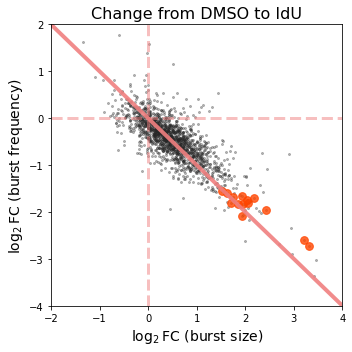

In [469]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))
pair = [0,1]
sr_arr_desai = [monod.analysis.load_search_results('./fits/'+desai_batch_dir+'/'+x+'/'+desai_fit_settings+'/grid_scan_results_upd.res') for x in desai_datasets]
gf_highnoise = plot_marker_gene_bs_k_diffs(sr_arr_desai,pair,desai_markers,desai_condition_names,ax1,
                            'condition_colors_desai',xl = [-2,4],means=means_desai,fc_thr=1.5)
for x  in sr_arr_desai[0].gene_names[gf_highnoise]:
    print(x)
fig1.tight_layout()
fig1.savefig('./'+figdir+'/desai_foldchanges.png',dpi=450)
